In [1]:
import time
import sys

sys.path.append('/home/cjw/Code/Unet')
#sys.path.append('/media/cjw/PythonLib/Unet')
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import unet2d

%matplotlib inline

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf

In [3]:
params = dict()

params['width'] = 256
params['height'] = 256
params['nchannels'] = 3
params['channels'] = [0,1,2]
params['nepochs'] = [1]
params['batchsize'] = [512]
params['learning_rate'] = 0.001
params['restore'] = False
params['latent_size'] = 1
params['enc_sizes'] = [[16,5, 2], [32, 3, 2],
                       [64, 3, 2], [128, 3, 2], [256, 3, 2]]

params['dec_sizes'] = [[128,3, 2], [64, 3, 2],
                       [32, 3, 2], [16, 5, 2], [5, 3, 2]]
params['droprate'] = 0.1
params['stdev'] = 0.04

In [4]:
    
## read in the data
data_tif = imread('/ssd1/cjw/Data/sez/NDExp.tif')
labels_tif = imread('/ssd1/cjw/Data/sez/NDExp_labels.tif')
print(labels_tif.shape)

rtemp = np.zeros(labels_tif.shape[0:3] + (2,))
rtemp[:,:,:,0] = labels_tif[:,:,:,0] + labels_tif[:,:,:,2]
rtemp[:,:,:,1] = labels_tif[:,:,:,1] + labels_tif[:,:,:,3]
labels_tif = rtemp
#labels_tif = np.moveaxis(labels_tif, 1, -1)

#create the background channel for the labels
labshape = labels_tif.shape
temp = np.zeros(labels_tif.shape[0:3] + (labshape[-1] + 1,), dtype=np.float32)
temp[:,:, :, 0:-1] = labels_tif
tsum = labels_tif.max() - labels_tif.max(axis=(-1))
temp[:,:,:, -1] = tsum
labels_tif = temp


#normalize images 0-1
#try normalizing wit zero mean and equal sdev

dmin = data_tif.min(axis=(1,2),keepdims=True)
dmax = data_tif.max(axis=(1,2),keepdims=True)
dmean = data_tif.mean(axis=(1,2),keepdims=True)
dstd = data_tif.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
data = (data_tif - dmean)/dstd
labels = (labels_tif - labels_tif.min())/(labels_tif.max() - labels_tif.min())

#put cells with both channels into channel 0
lsum = labels.sum(axis=(-1))
s2 = lsum > 1
s2 = s2.astype(np.float32)
labels[:,:,:,1] -= s2 
data_tif.shape, data.shape, labels.shape, labels_tif.shape

(9, 512, 512, 4)


((9, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3), (9, 512, 512, 3))

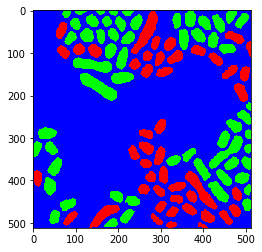

In [5]:
plt.imshow(labels[-1,:,:,:])

(3, 512, 512) float32 float32


((9, 512, 512, 5), (9, 512, 512, 2))

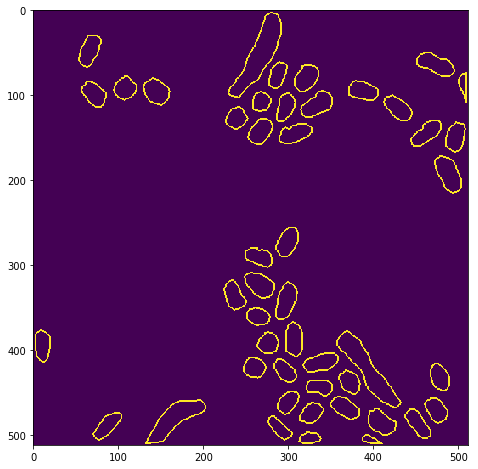

In [6]:

def get_outline(a, ch):
    
    b = a[:,:,ch] 
    b[np.where(b > 0)] = 1
    
    e0 = distance_transform_edt(b)
    ew = np.where(np.logical_and(e0 >= 1, e0 <=2))
    ew0 = np.zeros(b.shape, dtype=a.dtype)
    ew0[ew] = 1
    return ew0, ew

z = labels.copy()

ch4= np.zeros((labels.shape[0:-1] + (labshape[-1],)), dtype=np.float32)

for i in range(labels.shape[0]):
    ch = 0
    q0, qw0 = get_outline(labels[i], ch)
    z[i,:,:,0][qw0] = 0
    
    ch = 1
    q1, qw1 = get_outline(labels[i], ch)
    z[i,:,:,1][qw1] = 0
    
#     ch = 2
#     q2, qw2 = get_outline(labels[i], ch)
#     z[i,:,:,2][qw1] = 0
    
#     ch = 3
#     q3, qw3 = get_outline(labels[i], ch)
#     z[i,:,:,3][qw1] = 0
    
    ch4[i,:,:,0] = q0
    ch4[i,:,:,1] = q1
#     ch4[i,:,:,2] = q2
#     ch4[i,:,:,3] = q3

plt.figure(figsize=(8,8))
z = np.concatenate([z, ch4], axis=-1)
labels = z

print(labels[0,:,:,[0,1,3]].shape, ch4.dtype, labels.dtype)
plt.imshow(labels[-1,:,:,-2]) # + .5*labels[-1,:,:,4] + .25*labels[-1,:,:,-1])
labels.shape, labshape

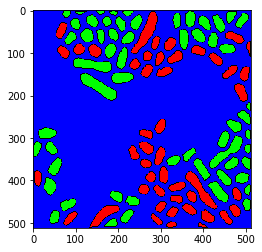

In [7]:
nv = -1
sh = [0,1,2]
pd = np.zeros((512, 512, 3), dtype=np.float32)
pd[:,:,0] = labels[nv, :,:,sh[0]]
pd[:,:,1] = labels[nv, :,:,sh[1]]
pd[:,:,2] = labels[nv ,:,:,sh[2]]
plt.imshow(pd)

In [8]:

tf.reset_default_graph()
u = unet2d.unet2d(params)
u.x = data
u.y = labels

In [9]:
test_images = imread('/ssd1/cjw/Data/sez/test.tif')
tmean = test_images.mean(axis=(1,2),keepdims=True)
tstd = test_images.std(axis=(1,2),keepdims=True)

#data = (data_tif - dmin)/(dmax - dmin)
test_images = (test_images - tmean)/tstd
u.xtest = test_images
print(test_images.std(axis=(1,2)))
u.xtest.shape, u.xtest.mean(axis=(1,2)).shape,u.xtest.mean(axis=(1,2)), u.xtest.min(axis=(1,2)), u.xtest.max(axis=(1,2))

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


((4, 512, 512, 3),
 (4, 3),
 array([[ 8.67361738e-19,  4.33680869e-18, -1.47451495e-17],
        [ 2.42861287e-17, -2.77555756e-17,  1.73472348e-18],
        [-1.02999206e-17,  9.75781955e-18, -2.94902991e-17],
        [ 6.50521303e-18, -8.67361738e-18,  1.73472348e-17]]),
 array([[-0.77434923, -0.67069198, -5.75321835],
        [-0.80996298, -0.51847166, -5.15309134],
        [-1.16963105, -0.85580761, -4.75164339],
        [-1.44531311, -0.77003683, -4.44155761]]),
 array([[ 6.24956098,  6.31317096,  7.96252817],
        [ 8.99004117,  7.3174952 ,  6.62614886],
        [ 6.19657008,  5.88927642,  6.74214584],
        [10.81873288, 10.72657588,  6.89048635]]))

In [10]:
w = 256

In [11]:
tf.reset_default_graph()
images = tf.placeholder(tf.float32, (None, w, w, params['nchannels']))
masks = tf.placeholder(tf.float32, (None, w, w, labels.shape[-1]))
learning_rate = tf.placeholder(tf.float32, ())
u.learning_rate = learning_rate

In [12]:
enc = u.create_encoder(images, True)

[16, 5, 2] <class 'int'>
[32, 3, 2] <class 'int'>
[64, 3, 2] <class 'int'>
[128, 3, 2] <class 'int'>
[256, 3, 2] <class 'int'>


In [13]:
d = u.create_decoder()
u.create_loss(masks)
u.create_opt()

Tensor("decoder-layer-128/BiasAdd:0", shape=(?, 16, 16, 128), dtype=float32)
4 Tensor("Relu_7:0", shape=(?, 16, 16, 128), dtype=float32)
after concat Tensor("concat-128:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("Relu_8:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("decoder-layer-64/BiasAdd:0", shape=(?, 32, 32, 64), dtype=float32)
3 Tensor("Relu_5:0", shape=(?, 32, 32, 64), dtype=float32)
after concat Tensor("concat-64:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("Relu_9:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("decoder-layer-32/BiasAdd:0", shape=(?, 64, 64, 32), dtype=float32)
2 Tensor("Relu_3:0", shape=(?, 64, 64, 32), dtype=float32)
after concat Tensor("concat-32:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("Relu_10:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("decoder-layer-16/BiasAdd:0", shape=(?, 128, 128, 16), dtype=float32)
1 Tensor("Relu_1:0", shape=(?, 128, 128, 16), dtype=float32)
after concat Tensor("concat-16:0", shape=(?, 128, 128, 32), dt

In [14]:
#u.set_validation(20)
u.xtrain = u.x

In [15]:
sess = tf.Session()

In [16]:
# tf.summary.scalar('loss', u.loss)
# si = tf.slice(u.decoder, [5, 0, 0, 0, 0], [10,1,256,256, 1])

# si = si[:,:,:,:,0]
# print(si)
# tf.summary.image('res', si, max_outputs=1)    
# merged = tf.summary.merge_all()



# logdir = "logdir"
# logwriter = tf.summary.FileWriter(logdir, sess.graph)

In [17]:
sess.run(tf.global_variables_initializer())

(2, 256, 256, 3) (2, 256, 256, 5)


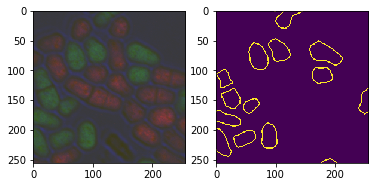

In [18]:
tb, tm = u.get_batch(2, erode=0)
tb = (tb - tb.min())/(tb.max() - tb.min())
print(tb.shape, tm.shape)
plt.subplot(1,2,1)
plt.imshow(tb[1,:,:,:])
plt.subplot(1,2,2)
plt.imshow(tm[-1,:,:,-1])

(256, 256, 5)


(256, 256)

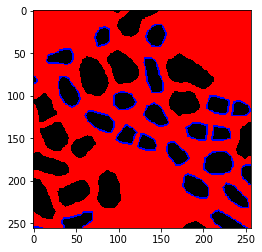

In [19]:
bz = tm[1]
print(bz.shape)
bz[:,:,-2] = 0

bzm = bz.max(axis=-1)
bz[:,:,-1] = 1 - bzm
plt.imshow(bz[:,:,-3:])
bzm.shape

In [20]:
u.stdev = 0.1
#u.learning_rate = 0.0001

0 1.7364466 1.7364466 8.1715775e-08 0.9998381 0.0029982
0


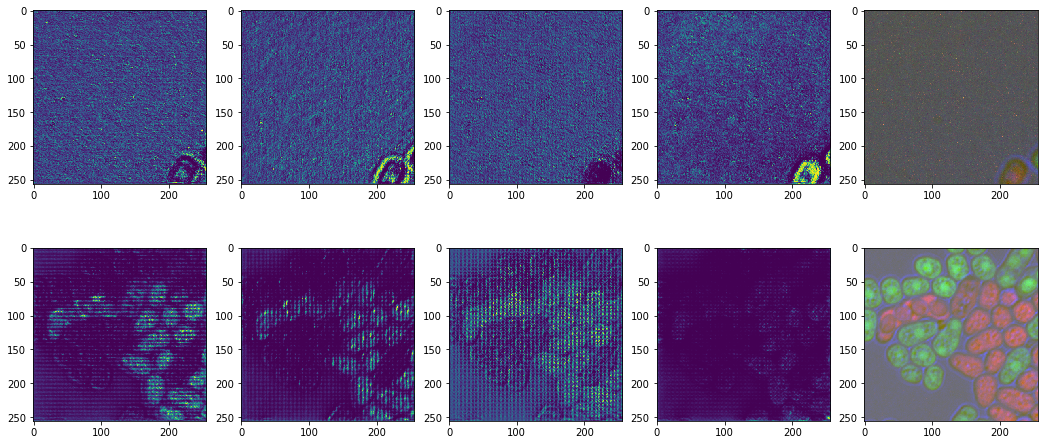

0 1.7364466 7.920520067214966 0.0029982
10 0.6066578 1.8212058544158936 0.0029802592932081954
20 0.54174006 2.108640193939209 0.0029624259404822267
30 0.384214 2.102001905441284 0.002944699299434054
40 0.3670551 1.6232576370239258 0.002927078731519579
50 0.3269962 2.1570327281951904 0.0029095636020156357
60 0.3655683 2.0717155933380127 0.0028921532799971337
70 0.29447436 2.263235092163086 0.002874847138314328
80 0.28403357 2.161708354949951 0.0028576445535702286
90 0.30824322 1.9993906021118164 0.0028405449060981444
100 0.2834226 0.2834226 5.6580695e-11 0.99935585 0.0028235475799393613
1


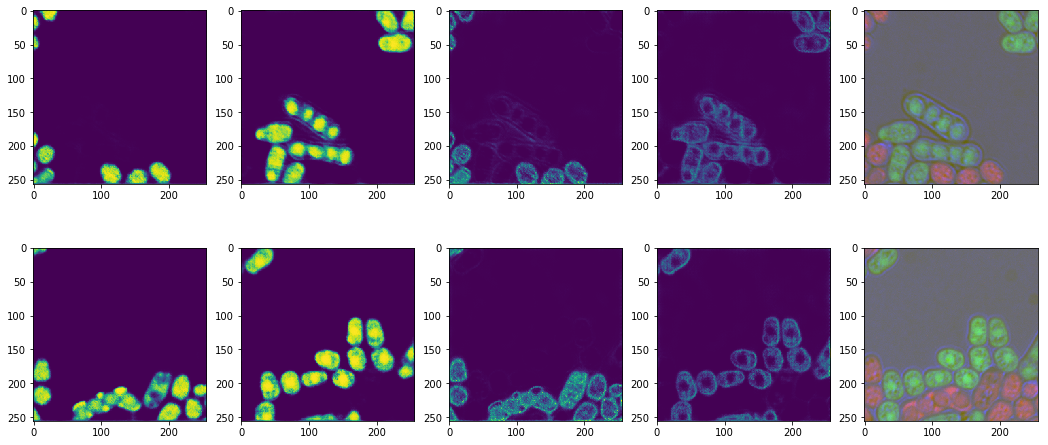

100 0.2834226 3.422534704208374 0.0028235475799393613
110 0.32752115 2.5389323234558105 0.002806651962820956
120 0.29818705 2.528153896331787 0.002789857446133739
130 0.3345807 3.023297071456909 0.0027731634249103325
140 0.26456624 2.290623426437378 0.002756569297803377
150 0.2960598 2.1701455116271973 0.002740074467063872
160 0.2642558 2.306994915008545 0.002723678338519643
170 0.29013577 2.5235979557037354 0.0027073803215539394
180 0.29534099 2.3974051475524902 0.002691179829084157
190 0.29600707 2.5196852684020996 0.0026750762775406907
200 0.27787316 0.27787316 4.4861012e-13 0.9996624 0.002659069086845917
13


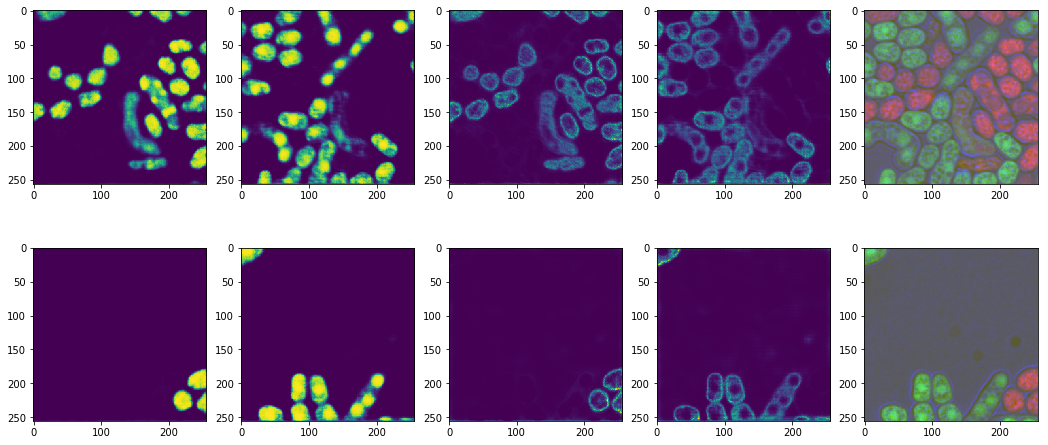

200 0.27787316 3.8797950744628906 0.002659069086845917
210 0.26390082 2.4760849475860596 0.0026431576803932935
220 0.2766486 3.3070335388183594 0.0026273414850265923
230 0.29112053 3.299520254135132 0.002611619931019252
240 0.26164714 2.624906301498413 0.002595992452053856
250 0.27223477 2.184044361114502 0.002580458485201733
260 0.29698744 2.1991281509399414 0.0025650174709026773
270 0.26843327 3.138184070587158 0.0025496688529447952
280 0.26579612 2.5685482025146484 0.002534412078444468
290 0.25598 2.129106283187866 0.0025192465978264365
300 0.26132202 0.26132202 8.491227e-17 0.9997172 0.002504171864804005
12


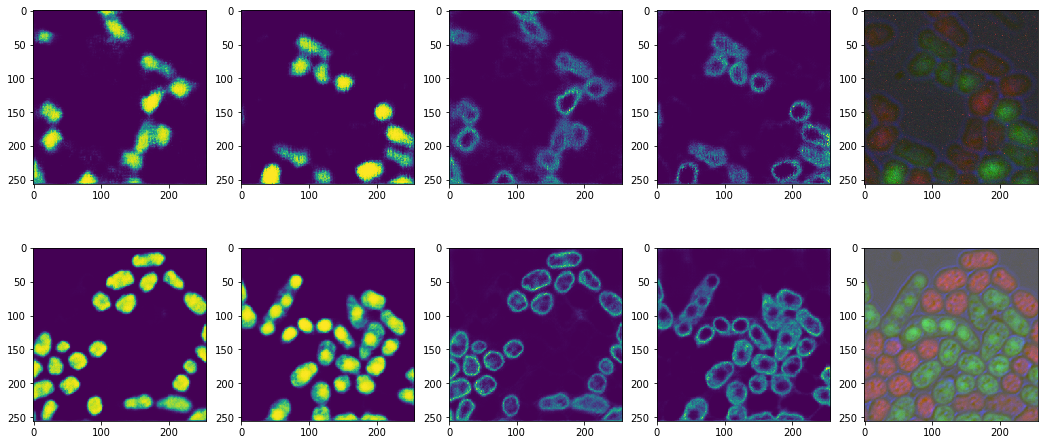

300 0.26132202 3.181171178817749 0.002504171864804005
310 0.27585334 2.7193992137908936 0.0024891873363593595
320 0.2550875 2.5130505561828613 0.002474292472724012
330 0.2581612 2.2416913509368896 0.002459486737359356
340 0.27316478 2.4195966720581055 0.002444769596937337
350 0.25988966 2.6962718963623047 0.0024301405213212426
360 0.29752433 2.1007814407348633 0.002415598983546607
370 0.2660885 2.5019330978393555 0.0024011444598022293
380 0.27011338 2.3646836280822754 0.0023867764294113014
390 0.2587595 3.127932548522949 0.0023724943748126555
400 0.27664182 0.27664182 7.1724014e-24 1.0 0.0023582977815421193
0


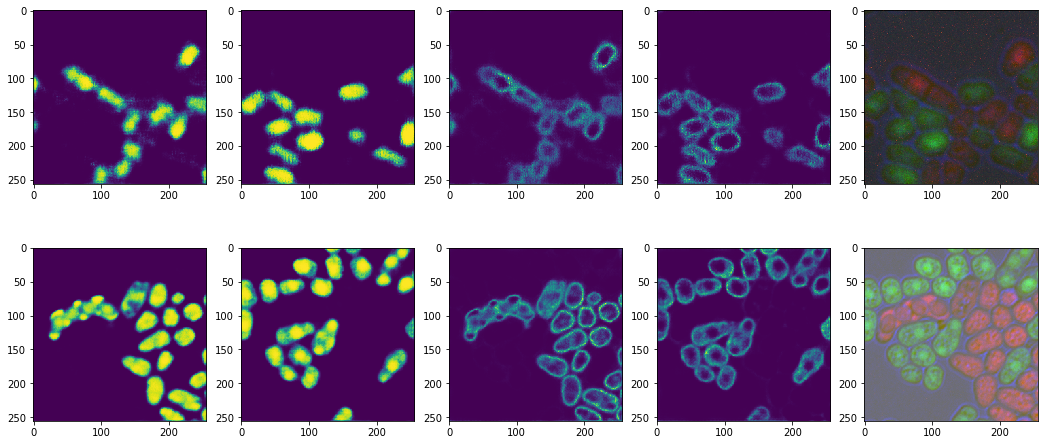

400 0.27664182 2.8181262016296387 0.0023582977815421193
410 0.27617636 2.7169601917266846 0.0023441861382139857
420 0.23748723 2.2077696323394775 0.0023301589365025887
430 0.25585052 2.404834508895874 0.0023162156711239953
440 0.25839058 3.0608553886413574 0.002302355839817804
450 0.2674073 3.0114383697509766 0.0022885789433290545
460 0.2584922 3.4338767528533936 0.002274884485390236
470 0.2617978 2.2579619884490967 0.00226127197270342
480 0.24847433 2.574368476867676 0.0022477409149224852
490 0.26777416 2.4067561626434326 0.002234290824635457
500 0.26514947 0.26514947 7.9282006e-14 0.999995 0.002220921217346948
14


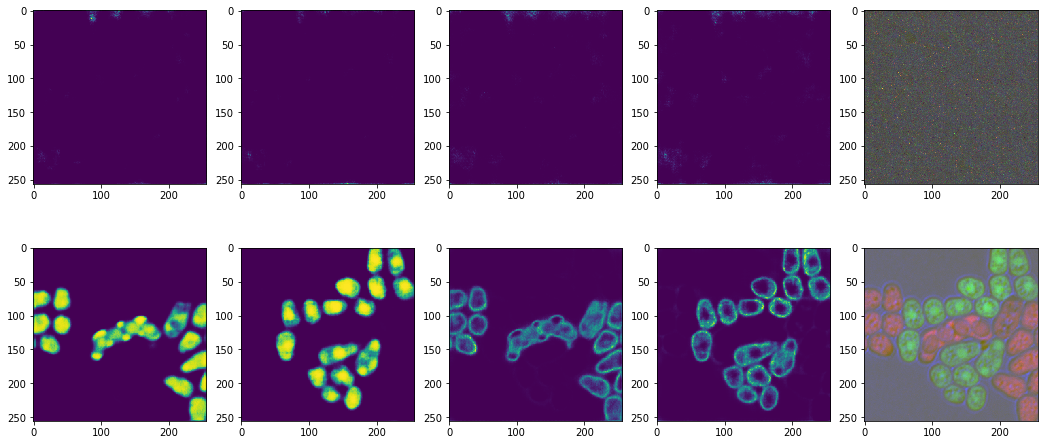

500 0.26514947 2.968353509902954 0.002220921217346948
510 0.24679326 2.7484350204467773 0.002207631611460709
520 0.24854937 2.2925992012023926 0.002194421528262278
530 0.28395998 2.4642512798309326 0.0021812904919017353
540 0.25939724 1.8264002799987793 0.002168238029376566
550 0.24390355 2.244020462036133 0.0021552636705146197
560 0.25055295 3.3823015689849854 0.0021423669479571747
570 0.25709665 2.415571928024292 0.0021295473971421008
580 0.24763238 2.2951478958129883 0.002116804556287128
590 0.23122713 2.873607635498047 0.002104137966373211
600 0.2661375 0.2661375 6.02452e-20 1.0 0.0020915471711279946
0


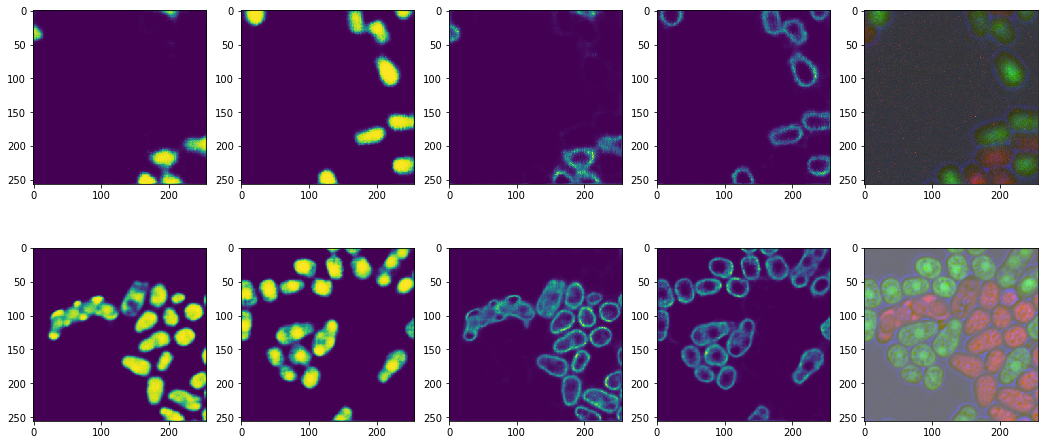

600 0.2661375 3.1436173915863037 0.0020915471711279946
610 0.25997305 2.2852566242218018 0.0020790317170093775
620 0.272257 2.668905258178711 0.0020665911531891753
630 0.24943906 1.9286770820617676 0.002054225031536882
640 0.2387153 3.4037623405456543 0.002041932906603525
650 0.253398 2.738961696624756 0.002029714335605623
660 0.24015766 2.6695008277893066 0.0020175688784092303
670 0.26836935 2.553022861480713 0.0020054960975140895
680 0.22423005 2.0466437339782715 0.0019934955580378673
690 0.2538537 2.5457725524902344 0.0019815668277004908
700 0.25457683 0.25457683 1.7136361e-15 0.9999988 0.001969709476808575
9


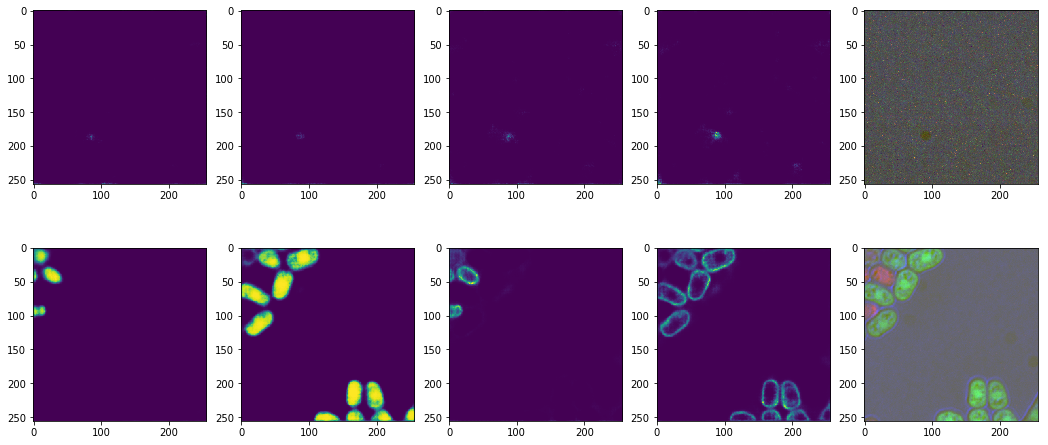

700 0.25457683 3.779528856277466 0.001969709476808575
710 0.25920054 2.3072118759155273 0.001957923078239946
720 0.2421292 2.346602439880371 0.0019462072074282553
730 0.24597439 2.9208474159240723 0.001934561442347684
740 0.2424744 2.316636323928833 0.0019229853634977433
750 0.25510442 3.2318902015686035 0.0019114785538881624
760 0.24584335 2.251560926437378 0.0019000405990238667
770 0.23937389 2.2434544563293457 0.001888671086890049
780 0.21286653 2.6319949626922607 0.001877369607937326
790 0.2597187 2.3020997047424316 0.0018661357550669873
800 0.24693225 0.24693225 7.137107e-16 0.99999976 0.0018549691236163302
6


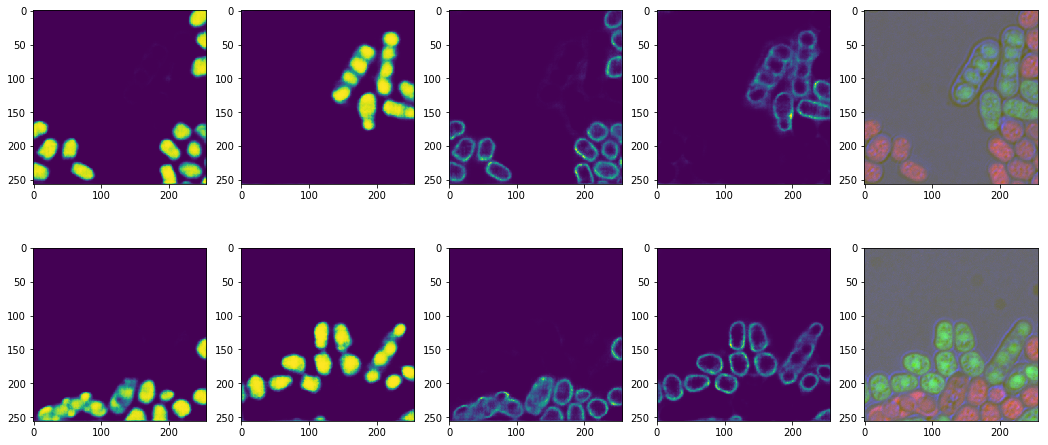

800 0.24693225 3.1034045219421387 0.0018549691236163302
810 0.24653098 2.592600107192993 0.0018438693113440828
820 0.2550559 2.9942116737365723 0.0018328359184159155
830 0.2468386 2.28823184967041 0.0018218685473900369
840 0.2569627 2.2475242614746094 0.0018109668032028794
850 0.24495767 2.338378429412842 0.0018001302931548657
860 0.24610345 2.963454484939575 0.0017893586268962645
870 0.26518312 2.4117918014526367 0.0017786514164131303
880 0.24621914 2.9569647312164307 0.001768008276013325
890 0.23477347 3.124974489212036 0.0017574288223126248
900 0.21607202 0.21607202 3.820734e-15 1.0 0.0017469126742209102
3


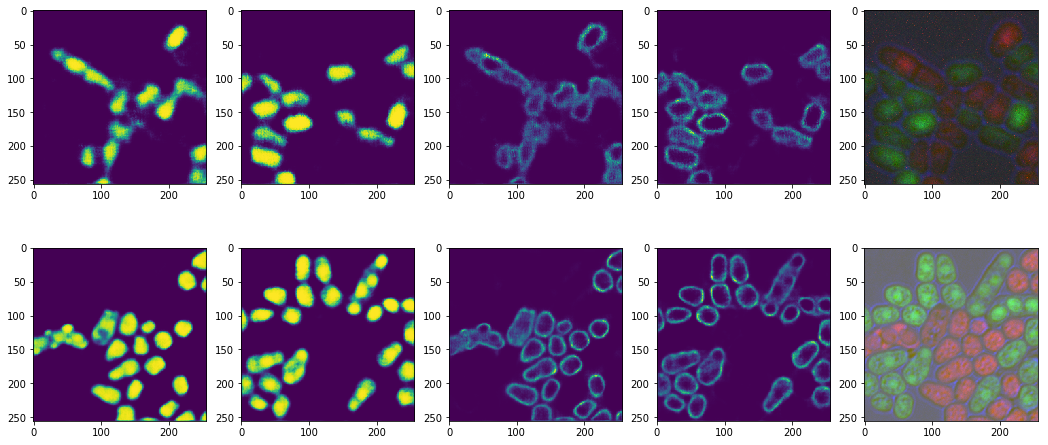

900 0.21607202 2.532892942428589 0.0017469126742209102
910 0.22182867 2.270968437194824 0.0017364594529284396
920 0.2319813 3.5355231761932373 0.0017260687818922021
930 0.236592 2.3102126121520996 0.0017157402868223548
940 0.25887063 3.091309070587158 0.0017054735956687403
950 0.23698889 3.010615348815918 0.0016952683386074843
960 0.24685407 2.0917253494262695 0.0016851241480276738
970 0.24672599 2.3857946395874023 0.0016750406585181166
980 0.2523299 2.436113119125366 0.0016650175068541762
990 0.26568884 2.045077085494995 0.0016550543319846902
1000 0.23219582 0.23219582 2.244166e-16 0.99999356 0.001645150775018963
1


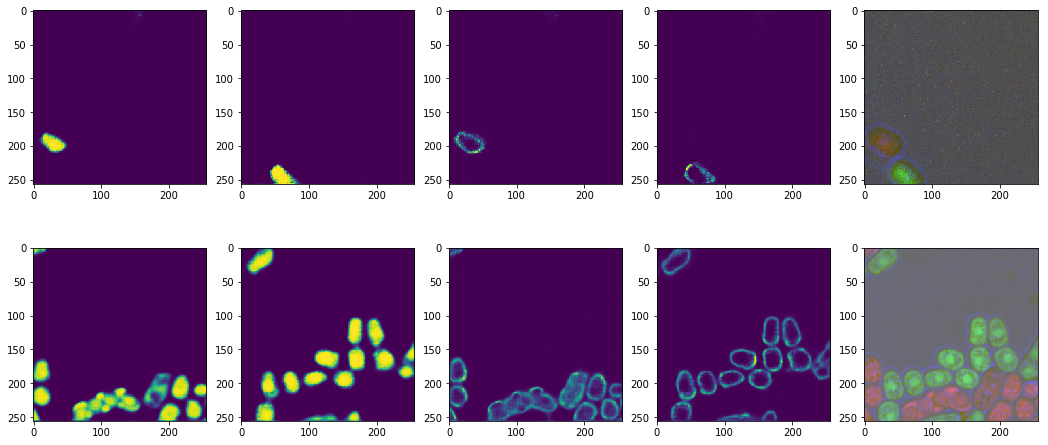

1000 0.23219582 3.64201283454895 0.001645150775018963
1010 0.25215113 2.334537982940674 0.0016353064792138379
1020 0.25273544 2.4397919178009033 0.0016255210899608482
1030 0.24673556 2.931434154510498 0.0016157942547734415
1040 0.2333506 2.5197958946228027 0.001606125623274284
1050 0.23898017 2.109729051589966 0.0015965148471826394
1060 0.21789943 2.213869333267212 0.001586961580301822
1070 0.23363575 2.483786106109619 0.0015774654785067265
1080 0.24627629 2.3717498779296875 0.0015680261997314334
1090 0.25007984 2.217130422592163 0.0015586434039568855
1100 0.23235579 0.23235579 6.1893886e-20 0.9999995 0.00154931675319864
1


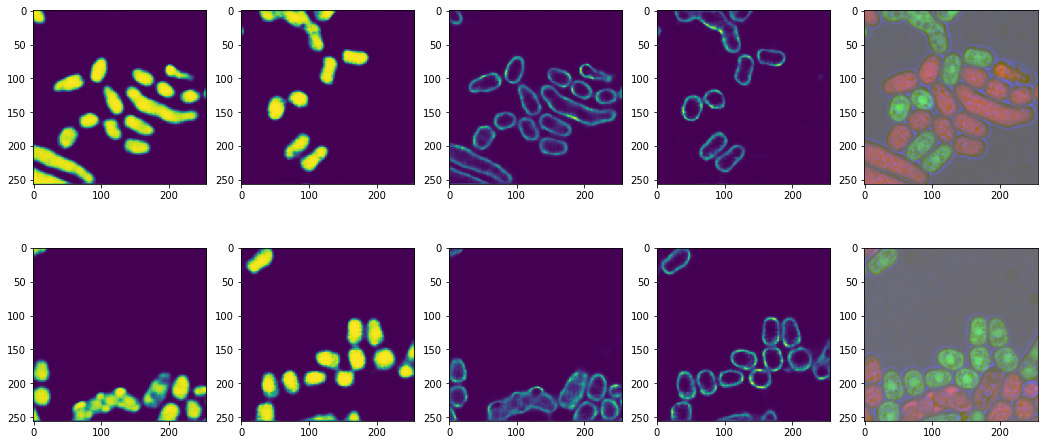

1100 0.23235579 3.047002077102661 0.00154931675319864
1110 0.2524324 3.16693377494812 0.0015400459114946951
1120 0.23308918 2.39243221282959 0.0015308305448933862
1130 0.23795794 2.2678310871124268 0.0015216703214413578
1140 0.2113298 2.2045512199401855 0.0015125649111716053
1150 0.24063432 2.699209213256836 0.0015035139860915896
1160 0.225008 2.010633707046509 0.0014945172201714218
1170 0.25396907 2.31033992767334 0.0014855742893321183
1180 0.23840994 2.071417808532715 0.0014766848714339287
1190 0.238614 2.841059446334839 0.0014678486462647304
1200 0.2260696 0.2260696 1.7136062e-13 1.0 0.0014590652955284943
1


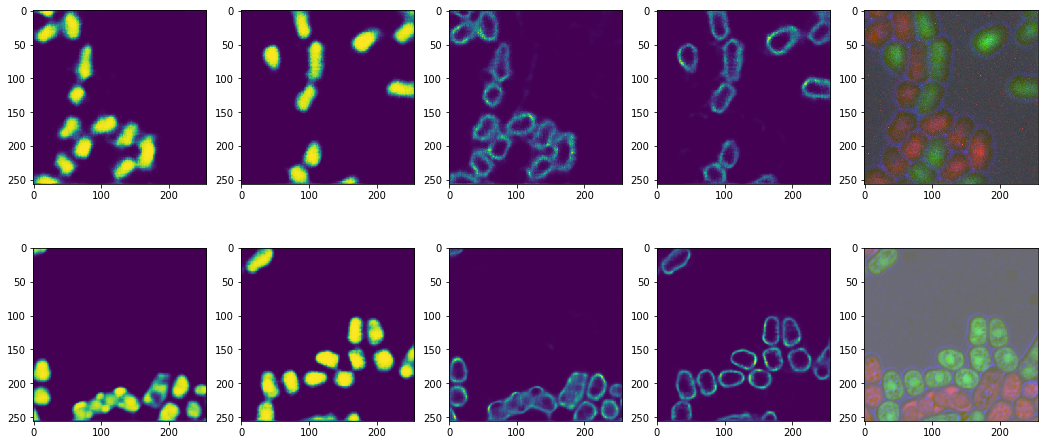

1200 0.2260696 2.7160017490386963 0.0014590652955284943
1210 0.24931167 2.1383888721466064 0.001450334502833819
1220 0.2340439 2.5431511402130127 0.001441655953682535
1230 0.2185626 2.2969305515289307 0.0014330293354583746
1240 0.22983465 2.1970365047454834 0.001424454337415711
1250 0.22894135 2.3349833488464355 0.0014159306506683661
1260 0.23587602 2.366671085357666 0.001407457968178482
1270 0.22632837 2.278195858001709 0.0013990359847454621
1280 0.22531523 2.320236921310425 0.001390664396994978
1290 0.22405243 2.872891426086426 0.0013823429033680387
1300 0.23210026 0.23210026 1.4198776e-30 1.0 0.0013740712041101313
14


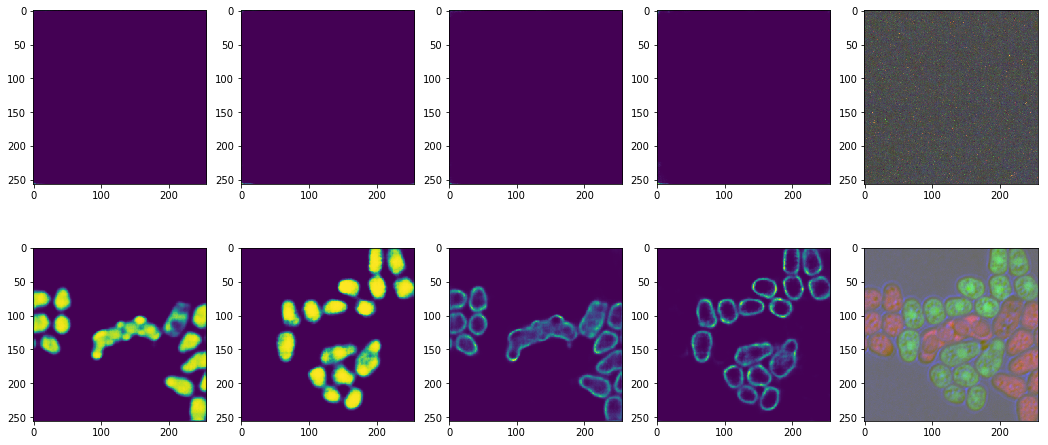

1300 0.23210026 3.1042582988739014 0.0013740712041101313
1310 0.23911294 2.329439878463745 0.0013658490012604207
1320 0.23202485 2.1978676319122314 0.0013576759986410182
1330 0.22893867 2.019700050354004 0.0013495519018463112
1340 0.22023198 1.9876604080200195 0.0013414764182323605
1350 0.22948924 2.3066225051879883 0.0013334492569063558
1360 0.2056256 2.0829310417175293 0.001325470128716139
1370 0.24962984 2.2876689434051514 0.001317538746239789
1380 0.23040107 2.6441595554351807 0.0013096548237752665
1390 0.2385356 2.967109441757202 0.0013018180773301245
1400 0.22585839 0.22585839 2.9097714e-12 0.9999912 0.0012940282246112758
6


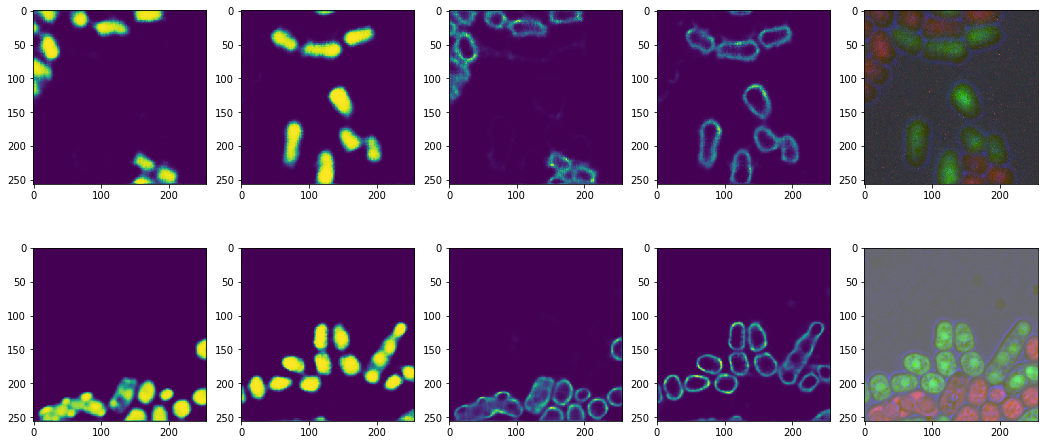

1400 0.22585839 4.00289249420166 0.0012940282246112758
1410 0.22872879 2.2333669662475586 0.0012862849850148277
1420 0.22344902 3.1982529163360596 0.001278588079615971
1430 0.22212535 3.016247034072876 0.0012709372311589342
1440 0.23784228 2.522459030151367 0.0012633321640469963
1450 0.212693 2.303330898284912 0.0012557726043325597
1460 0.23898429 3.3276500701904297 0.0012482582797072807
1470 0.22995956 2.427337408065796 0.001240788919492261
1480 0.22111689 3.2163219451904297 0.0012333642546282987
1490 0.20670334 2.3685343265533447 0.0012259840176661945
1500 0.2157292 0.2157292 1.6223336e-15 1.0 0.0012186479427571198
3


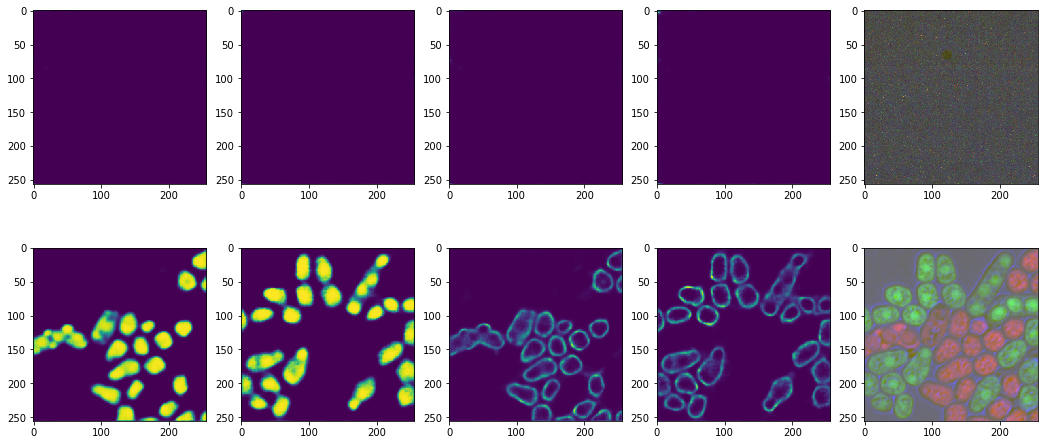

1500 0.2157292 2.8767988681793213 0.0012186479427571198
1510 0.2273984 2.462977409362793 0.0012113557656430371
1520 0.2056377 2.499039649963379 0.0012041072236471848
1530 0.23149945 2.149271011352539 0.0011969020556646121
1540 0.21664944 2.014420747756958 0.001189740002152776
1550 0.20164716 2.2850499153137207 0.0011826208051221895
1560 0.20781319 2.275127649307251 0.0011755442081271307
1570 0.23081726 2.185438394546509 0.0011685099562564038
1580 0.20751253 2.1468679904937744 0.0011615177961241572
1590 0.2130448 2.6556360721588135 0.001154567475860757
1600 0.21475813 0.21475813 2.1107056e-18 1.0 0.001147658745103712
15


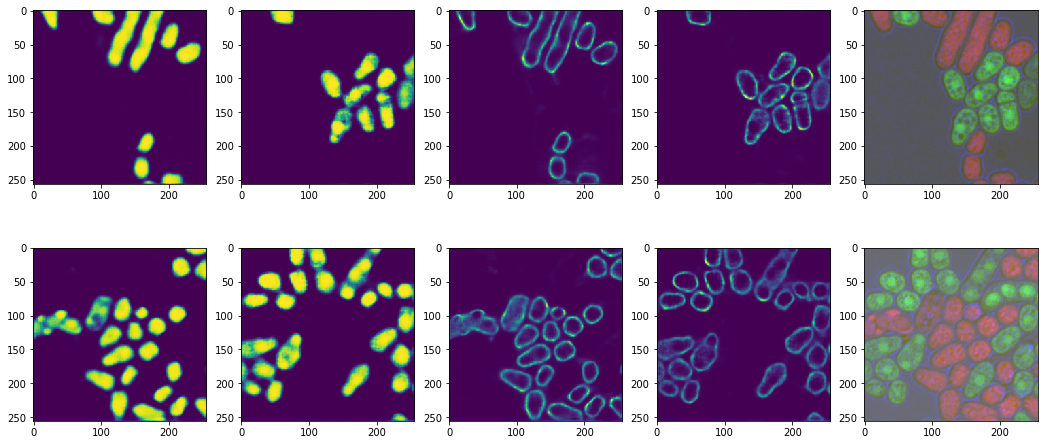

1600 0.21475813 3.02609920501709 0.001147658745103712
1610 0.23613676 3.023456335067749 0.0011407913549886573
1620 0.20762508 2.173307418823242 0.001133965058140389
1630 0.21650217 3.0635907649993896 0.0011271796086639533
1640 0.22068013 3.300478935241699 0.0011204347621357898
1650 0.23295389 1.9035594463348389 0.0011137302755949241
1660 0.24912114 2.2783682346343994 0.0011070659075342196
1670 0.22176224 2.398531675338745 0.0011004414178916757
1680 0.24845254 2.476623773574829 0.0010938565680417814
1690 0.21566889 2.5313704013824463 0.0010873111207869194
1700 0.2390335 0.2390335 1.4302316e-19 1.0 0.001080804840348821
3


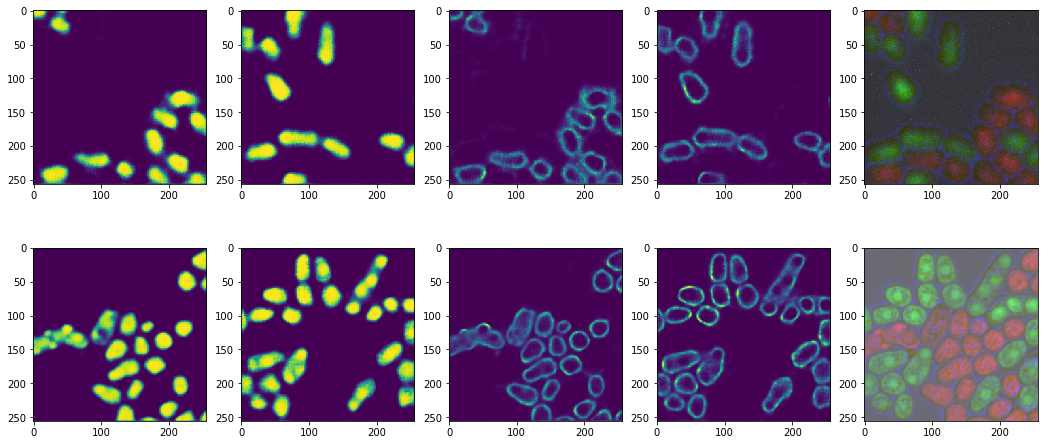

1700 0.2390335 3.1541402339935303 0.001080804840348821
1710 0.23122466 2.401745557785034 0.0010743374923600742
1720 0.21246359 2.4030168056488037 0.0010679088438556796
1730 0.2071453 2.125807762145996 0.0010615186632646615
1740 0.21565157 2.165079116821289 0.0010551667204017237
1750 0.23722693 2.285231351852417 0.0010488527864589588
1760 0.22357994 2.3849732875823975 0.0010425766339976063
1770 0.20009795 2.2229762077331543 0.001036338036939859
1780 0.20841962 2.1223254203796387 0.001030136770560721
1790 0.22129641 2.3571219444274902 0.0010239726114799105
1800 0.21712178 0.21712178 6.242258e-13 0.9999865 0.0010178453376538147
6


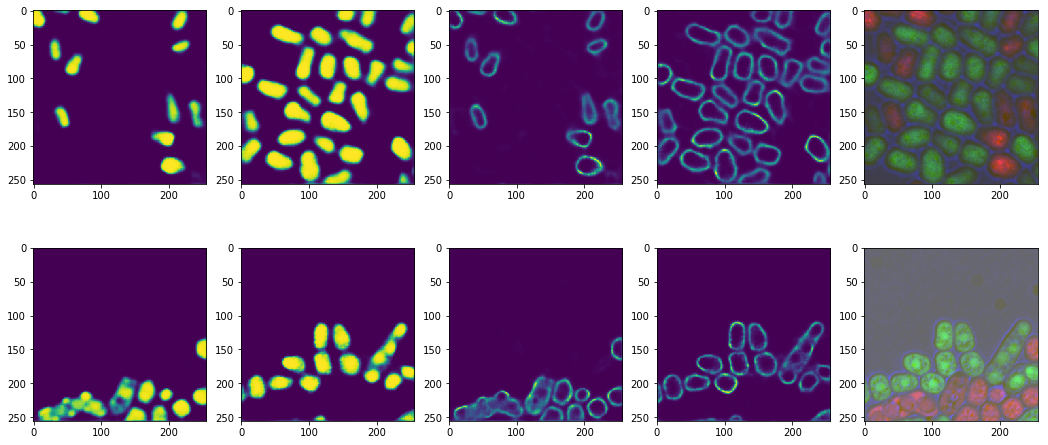

1800 0.21712178 3.085782527923584 0.0010178453376538147
1810 0.19307998 2.002206563949585 0.001011754728367492
1820 0.22240451 2.155060291290283 0.0010057005642267194
1830 0.2324932 2.1239566802978516 0.0009996826271500918
1840 0.23132992 2.289781332015991 0.0009937007003611648
1850 0.22383618 2.0617165565490723 0.0009877545683806461
1860 0.21286224 2.443763494491577 0.0009818440170186345
1870 0.22762272 2.0611517429351807 0.0009759688333669037
1880 0.21265343 1.933680772781372 0.0009701288057912332
1890 0.22236352 2.5971081256866455 0.0009643237239237844
1900 0.22382085 0.22382085 3.6285306e-16 1.0 0.0009585533786555242
15


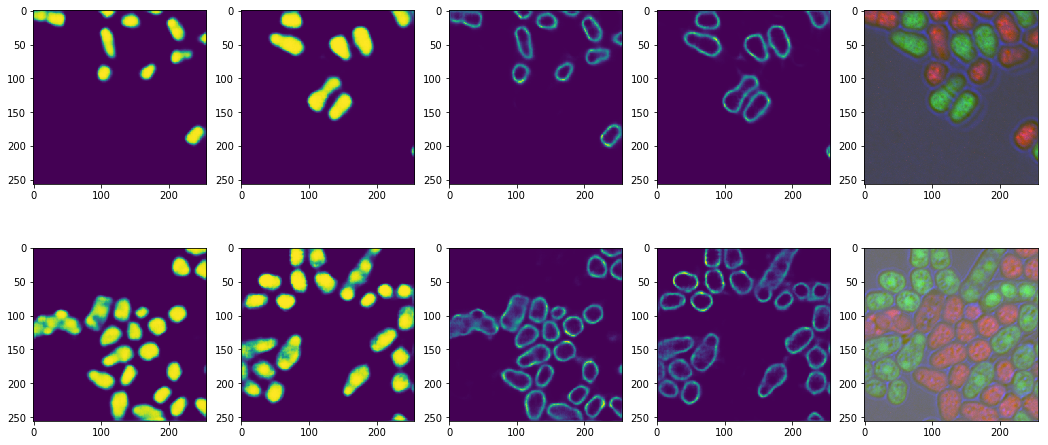

1900 0.22382085 3.525458812713623 0.0009585533786555242
1910 0.21928996 2.186044692993164 0.0009528175621286903
1920 0.21737301 2.484837532043457 0.0009471160677293062
1930 0.22661069 2.301523208618164 0.0009414486900797368
1940 0.20652571 2.2604174613952637 0.0009358152250312914
1950 0.229216 2.583648920059204 0.0009302154696568691
1960 0.2145693 3.087418556213379 0.0009246492222436494
1970 0.22190645 2.0948662757873535 0.0009191162822858269
1980 0.21954674 2.4275906085968018 0.0009136164504773873
1990 0.20985511 2.2287609577178955 0.0009081495287049287
2000 0.22196385 0.22196385 2.2564401e-13 0.9995104 0.0009027153200405264
4


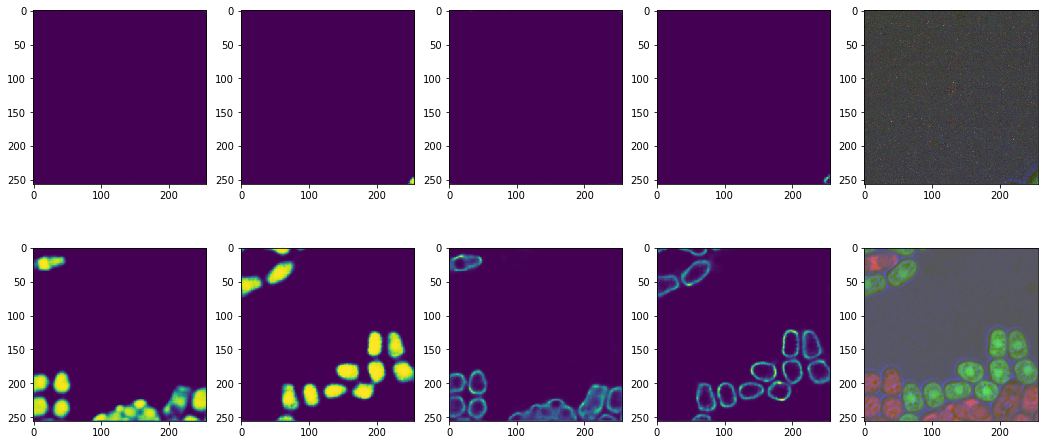

2000 0.22196385 2.9519424438476562 0.0009027153200405264


KeyboardInterrupt: 

In [21]:

rate = 0.003
#loss_file = open('progress.dat', 'w', buffering=1)

tbx, _ = u.get_batch(16, test=True, erode=0)
for i in range(2500):
    t1 = time.time()
    rate = np.maximum(rate*.9994, 0.000005)
    bx, bm = u.get_batch(256, erode=0)
#     plt.figure(figsize=(2,2))
#     plt.imshow(bm[0])
    _, res, err = sess.run([u.opt, u.decoder_softmax, u.loss],
                           feed_dict={images:bx, masks:bm, learning_rate:rate})
    if i % 100 == 0:
        print(i, err, err, res[0,:,:,:].min(), res[0,:,:,:].max(), rate)
        nr = np.random.randint(0,16)
        #nr = np.argmin(res[:,:,:,4].sum(axis=(1,2)))
        print(nr)
        
        tres = sess.run(u.decoder_softmax,
                           feed_dict={images:tbx, learning_rate:rate})
        
        plt.figure(figsize=(18,8))
        plt.subplot(2,5,1)
        plt.imshow(res[nr,:,:,0])
        plt.subplot(2,5,2)
        plt.imshow(res[nr,:,:,1])
        plt.subplot(2,5,3)
        plt.imshow(res[nr,:,:,3])
        plt.subplot(2,5,4)
        plt.imshow(res[nr,:,:,4])
        plt.subplot(2,5,5)
        bxd = bx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
        plt.subplot(2,5,6)
        plt.imshow(tres[nr,:,:,0])
        plt.subplot(2,5,7)
        plt.imshow(tres[nr,:,:,1])
        plt.subplot(2,5,8)
        plt.imshow(tres[nr,:,:,3])
        plt.subplot(2,5,9)
        plt.imshow(tres[nr,:,:,4])
        plt.subplot(2,5,10)
        bxd = tbx[nr,:,:,:]
        bxd = (bxd - bxd.min())/(bxd.max() - bxd.min())
        plt.imshow(bxd)
        
    
#         plt.imshow(res[nr,:,:,5])
#         plt.subplot(2,5,7)
#         plt.imshow(res[nr,:,:,6])
#         plt.subplot(2,5,8)
#         plt.imshow(res[nr,:,:,7])
#         plt.subplot(2,5,9)
#         plt.imshow(res[nr,:,:,8])
#         plt.subplot(1,6,4)
#         plt.imshow(res[nr,:,:,1])
#         plt.subplot(1,6,5)
#         plt.imshow(bm[nr,:,:,1])
#         plt.subplot(1,6,6)
#         plt.imshow(bx[nr,:,:,1])
        plt.show()
        #plt.savefig("images/image{0:05d}".format(i))
    t2 = time.time()
    if i % 10 == 0:
        print(i, err, (t2 - t1), rate)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 256, 5)


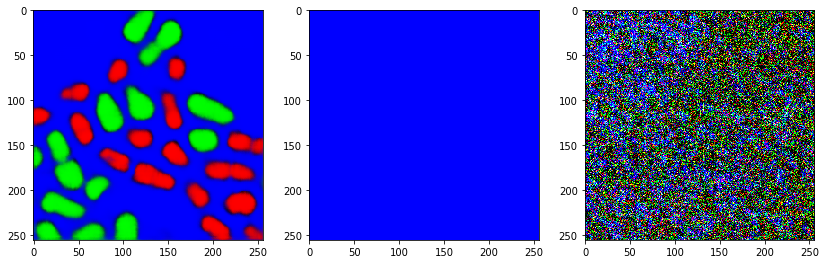

In [22]:
na = 13
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
print(bm.shape)
plt.imshow(res[na,:,:,0:3])
plt.subplot(1,3,2)
plt.imshow(bm[na,:,:,0:3])
plt.subplot(1,3,3)
plt.imshow(bx[na,:,:,:])


In [23]:
plt.hist(res[na,:,:,:].reshape((-1,3)))

ValueError: cannot reshape array of size 327680 into shape (3)

In [37]:
#test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/16_hours_punched_overnight/NDExp_Point0008_Seq0008.tif')
test_tif = imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0007_Seq0007.tif')
#test_tif = labels[-1,:,:,:] #imread('/ssd1/cjw/Data/sez/RawTifs/NDExp_Point0021_Seq0021.tif')
ymax = test_tif.max(axis=(0,1), keepdims=True)
ymin = test_tif.min(axis=(0,1), keepdims=True)
ymean = test_tif.mean(axis=(0,1), keepdims=True)
ystd = test_tif.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
test_tif = (test_tif - ymean)/ystd
test_tif.shape, ymin.shape

((2044, 2048, 3), (1, 1, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


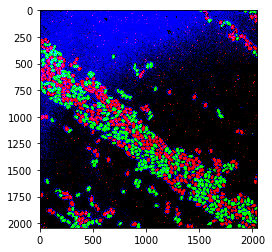

In [38]:
plt.imshow(test_tif)

In [39]:
def make_batch(data, start = 0):
    tclist = list()
    print(start)
    ix = start
    jy = start
    for i in range(6):
        jy = start
        for j in range(6):
            p = data[jy:jy + 256, ix:ix + 256,:]
            p = np.expand_dims(p, 0)
            tclist.append(p)
            jy = jy + 256
            #print(i, j, ix, jy)
        ix += 256

    tc = np.concatenate(tclist, axis=0)
    return tc

tc0 = make_batch(test_tif,start=0)
tc1 = make_batch(test_tif, start=128)
tc0.shape, tc1.shape

0
128


((36, 256, 256, 3), (36, 256, 256, 3))

In [40]:
vres0 = sess.run(u.decoder_softmax,
                feed_dict={images:tc0})

vres1 = sess.run(u.decoder_softmax,
                feed_dict={images:tc1})
vres0.shape, vres1.shape

((36, 256, 256, 5), (36, 256, 256, 5))

In [41]:
def reconstruct(v1, w, nx, ny, offset=0, pad=0):
    p = np.zeros((ny*w + pad, nx*w + pad, 5), dtype=np.float32)

    ix = offset
    jy = offset
    index = 0
    for i in range(nx):
        jy = offset
        for j in range(ny):
            p[jy:jy + 256, ix:ix + 256, :] = v1[index]
            jy = jy + 256
            index += 1
            #print(i, j, ix, jy)
        ix += 256
    return p
r0 = reconstruct(vres0, 256, 6, 6, offset=0, pad=128)
r1 = reconstruct(vres1, 256, 6, 6, offset=128, pad = 128)

r0 = np.expand_dims(r0, 0)
r1 = np.expand_dims(r1, 0)
r = np.concatenate([r0, r1])
r  = r.max(axis=(0))
r.shape, r.max()

((1664, 1664, 5), 1.0)

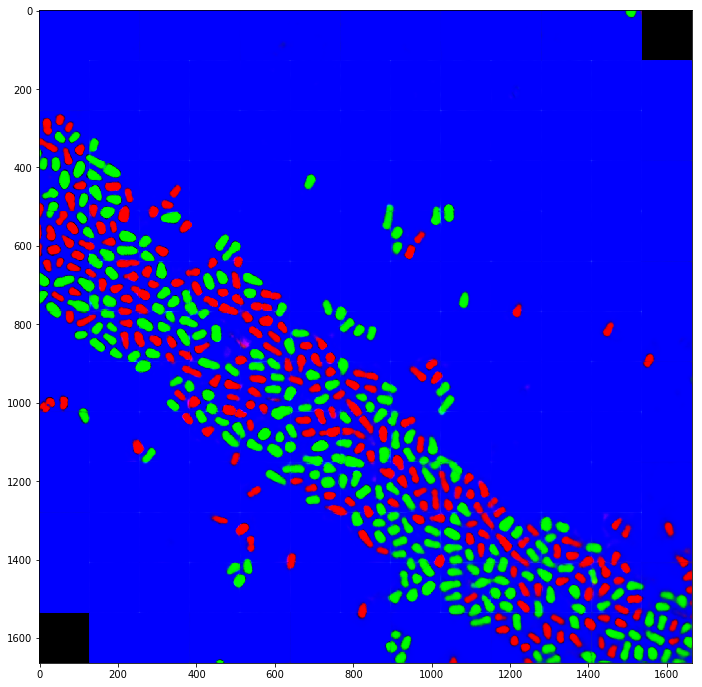

In [42]:

plt.figure(figsize=(12,12))

# az = r*0
# az[:,:,0] = r[:,:,-1]
# az[:,:,1] = r[:,:,-1]
# az[:,:,2] = r[:,:,-1]
# az = r - az

#plt.subplot(1,3,1)
plt.imshow(r[:,:,0:3]) #0[0,150:350,100:300,1])

#plt.subplot(1,3,4)
#plt.imshow(r0[0]) #[0,150:350,100:300,1])

#plt.subplot(1,3,3)
#plt.imshow(r1[0]) #[150:350,100:300,1])

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(test_tif[0:6*256+128, 0:6*256+128, :])

In [ ]:
plt.imshow(tc0[0,:,:,0])

In [ ]:
import tifffile
r.shape

In [ ]:
tifffile.imsave('/ssd1/cjw/Data/sez/unetout0017-2.tif', np.moveaxis(r, -1, 0))

In [ ]:
from skimage.morphology import binary_erosion

blab = labels[2, :,:,1]
plt.subplot(1,2,1)
plt.imshow(blab)
plt.subplot(1,2,2)
plt.imshow(binary_erosion(binary_erosion(blab)))
labels.shape

In [ ]:
plt.imshow(data[6,:,:,0:3])

In [ ]:
!%mkdir '/ssd1/cjw/sez/unet_checkpoint'

In [30]:
saver = tf.train.Saver()
saver.save(sess, '/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint', global_step=5000)

'/ssd1/cjw/sez/Checkpoints/2019-02-04-zero-mean/unet_checkpoint-5000'